In [1]:
import numpy as np
import pandas as pd
import os
import random
from IPython.display import display, HTML
import email
import re
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer 
from nltk import FreqDist
import csv
from nltk.corpus import stopwords

def content_filter(path, filename):

    file = open(path + filename,'r',errors='ignore')
    content = file.read()

    msg = email.message_from_string(content)
    if msg.is_multipart():
        body = []
        for payload in msg.get_payload():
            # if payload.is_multipart(): ...
            body.append(payload.get_payload())
        body = ' '.join('%s' %a for a in body)

    else:
        body = msg.get_payload()
    
    
    body_pp = body.lower()
    body_pp = re.sub(r"<[^<>]+>", ' ', body_pp) # remove html tag
    body_pp = re.sub(r"[0-9]+", ' number ', body_pp) # normalize numbers (0, 1, 2…) to “number”
    body_pp = re.sub(r"(http|https)://[^\s]*", ' httpaddr ', body_pp) # normalize URLs and to “httpaddr”
    body_pp = re.sub(r"[^\s]+@[^\s]+", ' emailaddr ', body_pp) # normalize email addresses to “emailaddr”
    body_pp = re.sub(r"[$]+", ' dollar ', body_pp) # normalize $ to “dollar”
    body_pp = re.sub(r"[^a-zA-Z0-9]",' ', body_pp) # remove non-alphanumerical characters
    body_token = word_tokenize(body_pp)
    stemmer = PorterStemmer()
    body_stem = [stemmer.stem(token) for token in body_token]
    body_stem = [x for x in body_stem if x != 'nbsp'] # non-breaking space in html and is meaningless in the context
    body_stem = [x for x in body_stem if len(x) > 1] # these are typically useless strings after stemming words
    body_stem = [x for x in body_stem if len(x) < 20] # they are usually strings in binary attachments
    StopWord = set(stopwords.words('english'))
    
    wordsfilter = []
    for w in body_stem:
        if w not in StopWord:
            wordsfilter.append(w)
    
    return wordsfilter

def words_freq(wordsfilter, headers):
    body_freq_dict = FreqDist(wordsfilter)
    data = [0]*101
    for i in range(len(headers)):
        for key in body_freq_dict:
            if headers[i] == key:
                data[i] = body_freq_dict.get(key)
    return data


if __name__ == '__main__' :
    spam_path = 'spam/spam/'
    ham_path = 'ham/ham/'

    email_files = {'spam': os.listdir(spam_path),
                   'ham': os.listdir(ham_path),
                  }
    # count number of emails for each folder
    print(' ***number of emails*** \n \
    spam emails: %d \n \
    ham emails: %d \n' %(len(email_files['spam']), len(email_files['ham']))
         )
    

    filename_spam = os.listdir(spam_path)
    filename_ham = os.listdir(ham_path)
    spam_stem = []
    
    for i in filename_spam:
        spam_stem = spam_stem + content_filter(spam_path, i)
        
    spam_freq_dict = FreqDist(spam_stem).most_common(100)
    
    headers = [i[0] for i in spam_freq_dict]
    headers.append('spam')

    with open('data.csv', 'w') as df:
        writer = csv.writer(df)
        writer.writerow(headers)
        for i in filename_spam:
            wf = content_filter(spam_path, i)
            data = words_freq(wf, headers)
            data[100] = '1'
            writer.writerow(data)
        for i in filename_ham:
            wf = content_filter(ham_path, i)
            data = words_freq(wf, headers)
            data[100] = '0'
            writer.writerow(data)

 ***number of emails*** 
     spam emails: 1397 
     ham emails: 2801 



Shape before feature selection using LogisticRegression:  (4198, 96)
Shape after feature selection using LogisticRegression:  (4198, 34)
NB
[[2654  147]
 [1027  370]]
Accuracy:  0.7203430204859457
Spam Recall:  0.2648532569792412
Spam Precision:  0.7156673114119922


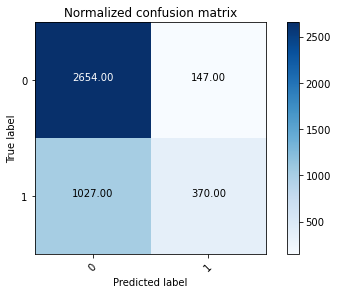


SVM
[[2642  159]
 [ 351 1046]]
Accuracy:  0.8785135778942353
Spam Recall:  0.7487473156764496
Spam Precision:  0.8680497925311204


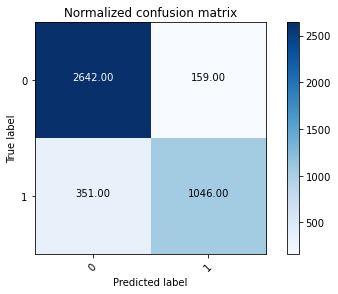


KNN
[[2608  193]
 [ 332 1065]]
Accuracy:  0.8749404478323011
Spam Recall:  0.7623478883321403
Spam Precision:  0.8465818759936407


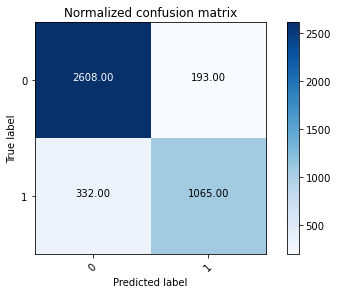

In [28]:
import numpy as np
import pandas as pd
import os
import csv
import itertools
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
import seaborn as sns
from sklearn.model_selection import KFold

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore")

def NBclassifier(x, y):
    # set to 10 folds
    kf = KFold(n_splits = 10)
    
    # model training
    predicted_y = np.array([]); expected_y = np.array([])
    
    for train_index, test_index in kf.split(x, y):
        x_train, x_test, y_train, y_test = x[train_index], x[test_index], y[train_index], y[test_index]
        
        # create and fit classifier
        classifier = GaussianNB()
        classifier.fit(x_train, y_train)
        
        tmp = classifier.predict(x_test)
        predicted_y = np.append(predicted_y, tmp)
        
        expected_y = np.append(expected_y, y_test)
        
    return predicted_y, expected_y

def SVMclassifier(x, y):
    # set to 10 folds
    kf = KFold(n_splits = 10)
    
    # model training
    predicted_y = np.array([]); expected_y = np.array([])
    
    for train_index, test_index in kf.split(x, y):
        x_train, x_test, y_train, y_test = x[train_index], x[test_index], y[train_index], y[test_index]
        
        # create and fit classifier
        classifier = svm.SVC(kernel = 'rbf', C = 1, gamma = 'auto')
        classifier.fit(x_train, y_train)
        
        tmp = classifier.predict(x_test)
        predicted_y = np.append(predicted_y, tmp)
        
        expected_y = np.append(expected_y, y_test)
        
    return predicted_y, expected_y


def KNNclassifier(x, y):
    # set to 10 folds
    kf = KFold(n_splits = 10)
    
    # model training
    predicted_y = np.array([]); expected_y = np.array([])
    
    for train_index, test_index in kf.split(x, y):
        x_train, x_test, y_train, y_test = x[train_index], x[test_index], y[train_index], y[test_index]
        
        # create and fit classifier
        classifier = KNeighborsClassifier(n_neighbors = 4)
        classifier.fit(x_train, y_train)
    
        tmp = classifier.predict(x_test)
        predicted_y = np.append(predicted_y, tmp)
        
        expected_y = np.append(expected_y, y_test)
        
    return predicted_y, expected_y

def spam_evaluation(predicted_y, expected_y):
    
    arr = confusion_matrix(expected_y, predicted_y, labels = [0, 1])
    print(arr)
    
    tp = arr[0][0]; tn = arr[1][1]; fn = arr[0][1]; fp = arr[1][0]; total = 0
    for i in range(2):
        for j in range(2):
            total += arr[i][j]
            
    print("Accuracy: ", (tp+tn)/total)
    print("Spam Recall: ", tn/(fp+tn))
    print("Spam Precision: ", tn/(fn+tn))


def generate_confusion_matrix(cnf_matrix, classes, normalize=False, title='Confusion matrix'):
    
    plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.get_cmap('Blues'))
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cnf_matrix.max() / 2.

    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, format(cnf_matrix[i, j], fmt), horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    return cnf_matrix    
    

def plot_confusion_matrix(predicted_y, expected_y):
    cnf_matrix = confusion_matrix(expected_y, predicted_y)
    np.set_printoptions(precision=2)

    # Plot normalized confusion matrix
    plt.figure()
    generate_confusion_matrix(cnf_matrix, classes=[0, 1], normalize=True, title='Normalized confusion matrix')
    plt.show()    

    
    
if __name__ == '__main__' :
    
    d = pd.read_csv('data.csv')
    
    rawdata = d.iloc[:, :-1].values
    y = d.iloc[:, -1].values
    
    
    ##### remove dependent variables since they do not contribute any additional information #####
    x_df = pd.DataFrame(rawdata)
    numerical = list(
        set(x_df.columns)
        - {
            x_df.columns[29],
            x_df.columns[31],
            x_df.columns[65],
            x_df.columns[77]
            }
        )
    
    x_hm = x_df[numerical]
    
    corr_matrix = x_hm.corr()
    sns.heatmap(corr_matrix, vmin = 0, vmax = 1)
    
    ##### data normalization #####
    x_norm = StandardScaler().fit_transform(x_hm)
    
    ##### feature selection #####
    print("Shape before feature selection using LogisticRegression: ", x_norm.shape)
    lrf = LogisticRegression(random_state = 0).fit(x_norm, y)
    model = SelectFromModel(lrf, prefit = True) # meta-transformer for selecting features based on importance weights.
    x = model.transform(x_norm)
    print("Shape after feature selection using LogisticRegression: ", x.shape)
    
    
    ##### model training & evaluation #####
    # NB
    print("NB")
    predicted_y_nb, expected_y_nb = NBclassifier(x, y)
    spam_evaluation(predicted_y_nb, expected_y_nb)
    plot_confusion_matrix(predicted_y_nb, expected_y_nb)
    
    # SVM
    print("\nSVM")
    predicted_y_svm, expected_y_svm = SVMclassifier(x, y)
    spam_evaluation(predicted_y_svm, expected_y_svm)
    plot_confusion_matrix(predicted_y_svm, expected_y_svm)
    
    # KNN
    print("\nKNN")
    predicted_y_knn, expected_y_knn = KNNclassifier(x, y)
    spam_evaluation(predicted_y_knn, expected_y_knn)
    plot_confusion_matrix(predicted_y_knn, expected_y_knn)

NN
14/14 [==============================] - 0s 1ms/step
[[2685  116]
 [ 248 1149]]
Accuracy:  0.9132920438303954
Spam Recall:  0.8224767358625626
Spam Precision:  0.908300395256917


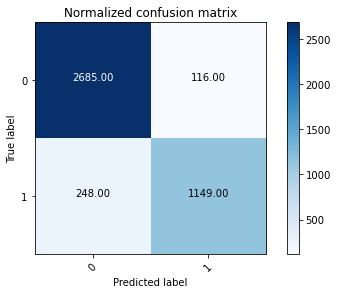

In [27]:
import numpy as np
import pandas as pd
import csv
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import confusion_matrix

def NNclassifier(x, y):
    # set to 10 folds
    kf = KFold(n_splits = 10)
    
    # model training
    predicted_y = np.array([]); expected_y = np.array([])
    
    # create and fit classifier
    clf = Sequential()
    clf.add(Dense(12, input_dim = 34, activation = 'sigmoid'))
    clf.add(Dense(8, activation = 'sigmoid'))
    clf.add(Dense(1, activation = 'sigmoid'))
    clf.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    
    for train_index, test_index in kf.split(x, y):
        x_train, x_test, y_train, y_test = x[train_index], x[test_index], y[train_index], y[test_index]
        
        clf.fit(np.array(x_train), np.array(y_train), epochs = 50, batch_size = 10, verbose = 0)

        tmp = (clf.predict(np.array(x_test)) > 0.5).astype(int)
        predicted_y = np.append(predicted_y, tmp)
        
        expected_y = np.append(expected_y, y_test)
        
    return predicted_y, expected_y
        
        
if __name__ == '__main__' :
    
    # NN
    print("NN")
    predicted_y_nn, expected_y_nn = NNclassifier(x, y)
    spam_evaluation(predicted_y_nn, expected_y_nn)
    plot_confusion_matrix(predicted_y_nn, expected_y_nn)